# **Realized Volatility Prediction**

STATS 507 Final Project  
Ching Hin Yeung

## 1 Data Understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot

In [2]:
# read response data (target volatility)
data_dir = 'data/'
train_dtypes = {'stock_id': np.uint8, 'time_id': np.uint16, 'target': np.float64}
df_train = pd.read_csv(data_dir + 'train.csv', dtype=train_dtypes)
df_train.head(5)

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [3]:
# evaluation metric (rmspe)
def rmspe(y_true, y_pred, epsilon=1e-10):
    return np.sqrt(np.mean(np.square((y_true - y_pred)/(y_true + epsilon))))

# brief understanding on response data (by stock)
target_mean_rmspe = rmspe(df_train['target'], np.repeat(df_train['target'].mean(), len(df_train)))
print(f'target Mean RMPSE: {target_mean_rmspe:.6}')
stock_id_target_mean_rmspe = rmspe(df_train['target'], df_train.groupby('stock_id')['target'].transform('mean'))
print(f'stock_id target Mean RMPSE: {stock_id_target_mean_rmspe:.6}')
stock_id_target_median_rmspe = rmspe(df_train['target'], df_train.groupby('stock_id')['target'].transform('median'))
print(f'stock_id target Median RMPSE: {stock_id_target_median_rmspe:.6}')

target Mean RMPSE: 1.11033
stock_id target Mean RMPSE: 0.789618
stock_id target Median RMPSE: 0.589135


In [4]:
# understand response data structure
def visualize_target(target):
    print(f'{target} volatility')
    print('-----------------------------------------------')
    
    # descriptive statistics
    print(f'Mean: {df_train[target].mean():.4f}   Median: {df_train[target].median():.4f}   Std: {df_train[target].std():.4f}')
    print(f'Min: {df_train[target].min():.4f}   25%: {df_train[target].quantile(0.25):.4f}   '
          f'50%: {df_train[target].quantile(0.5):.4f}   75%: {df_train[target].quantile(0.75):.4f}   '
          f'Max: {df_train[target].max():.4f}')
    print(f'Skew: {df_train[target].skew():.4f}   Kurtosis: {df_train[target].kurtosis():.4f}')

    # missing value check
    missing_values_count = df_train[df_train[target].isnull()].shape[0]
    training_samples_count = df_train.shape[0]
    print(f'Missing Values: {missing_values_count}/{training_samples_count} '
          f'({missing_values_count * 100 / training_samples_count:.4f}%)')

# visualize skewness
def skewness_check(target):
    fig1, ax1 = plt.subplots(figsize=(9, 6), dpi=100)
    sns.kdeplot(df_train[target], label=target, fill=True, ax=ax1)
    ax1.axvline(df_train[target].mean(), label=f'{target} Mean', color='r', linewidth=2, linestyle='--')
    ax1.axvline(df_train[target].median(), label=f'{target} Median', color='b', linewidth=2, linestyle='--')
    ax1.legend(prop={'size': 14})
    ax1.tick_params(axis='x', labelsize=12.5, pad=10)
    ax1.tick_params(axis='y', labelsize=12.5, pad=10)
    ax1.set_title(f'{target} Distribution in Training Set', fontsize=18, pad=12)
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    plt.show()

# normality check
def normality_check(target):
    fig2, ax2 = plt.subplots(figsize=(9, 6), dpi=100)
    probplot(df_train[target], plot=ax2)
    ax2.tick_params(axis='x', labelsize=12.5, pad=10)
    ax2.tick_params(axis='y', labelsize=12.5, pad=10)
    ax2.set_title(f'{target} Probability Plot', fontsize=18, pad=12)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    plt.show()

In [5]:
visualize_target('target')

target volatility
-----------------------------------------------
Mean: 0.0039   Median: 0.0030   Std: 0.0029
Min: 0.0001   25%: 0.0020   50%: 0.0030   75%: 0.0047   Max: 0.0703
Skew: 2.8226   Kurtosis: 14.9611
Missing Values: 0/428932 (0.0000%)


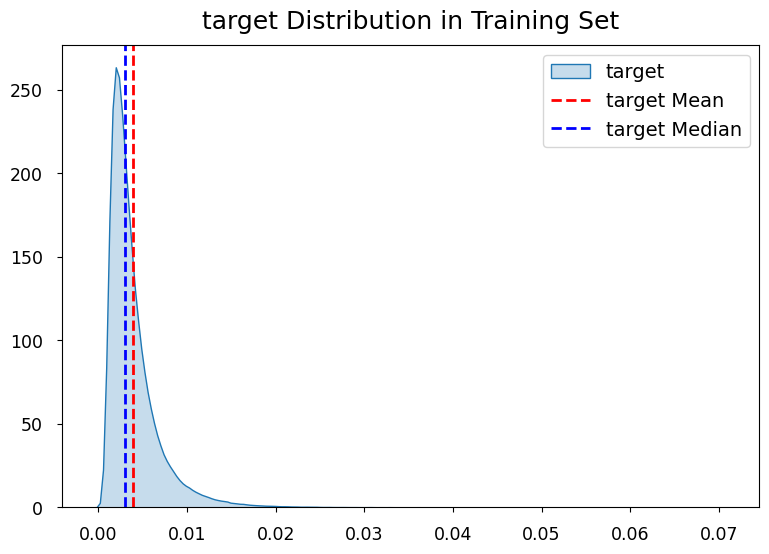

In [6]:
skewness_check('target')

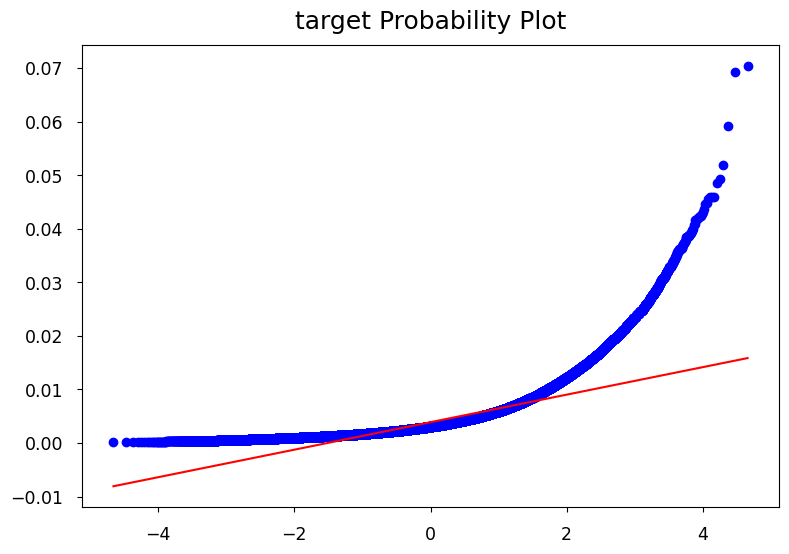

In [7]:
normality_check('target')

## 2 Feature Engineering

In [8]:
import warnings
from IPython.display import FileLink
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 150)

In [9]:
# weighted average price
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# log return and volatility
def log_return(series):
    return np.log(series).diff()
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

# count number of stocks
def count_unique(series):
    return len(np.unique(series))

In [10]:
# read train data
def read_train():
    train = pd.read_csv(data_dir + 'train.csv')
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    return train

In [11]:
# read and process (book/trade) train parquet
def preprocessor(list_stock_ids, is_train=True):
    df_list = []
    for stock_id in list_stock_ids:
        print(f"Processing stock_id: {stock_id}")
        if is_train:
            file_path_book = f"{data_dir}book_train.parquet/stock_id={stock_id}"
            file_path_trade = f"{data_dir}trade_train.parquet/stock_id={stock_id}"
        else:
            file_path_book = f"{data_dir}book_test.parquet/stock_id={stock_id}"
            file_path_trade = f"{data_dir}trade_test.parquet/stock_id={stock_id}"
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on='row_id', how='left')
        df_list.append(df_tmp)
    df = pd.concat(df_list, ignore_index=True)
    return df

In [12]:
# feature engineering for book data (create interaction term of statistics and different time window)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)

    # create descriptive statistics
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return).reset_index(drop=True)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return).reset_index(drop=True)
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

    # focus on sum, mean, and std of the above statistics
    create_feature_dict = {
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread': [np.sum, np.mean, np.std],
        'bid_spread': [np.sum, np.mean, np.std],
        'ask_spread': [np.sum, np.mean, np.std],
        'total_volume': [np.sum, np.mean, np.std],
        'volume_imbalance': [np.sum, np.mean, np.std]}

    # chose 150, 300, and 450 sec window because they are the 25th, 50th, and 75th percentile of our volatility window (10 minutes)
    def get_stats_window(seconds_in_bucket, add_suffix=False):
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    df_feature = get_stats_window(seconds_in_bucket=0, add_suffix=False)
    df_feature_450 = get_stats_window(seconds_in_bucket=450, add_suffix=True)
    df_feature_300 = get_stats_window(seconds_in_bucket=300, add_suffix=True)
    df_feature_150 = get_stats_window(seconds_in_bucket=150, add_suffix=True)
    df_feature = df_feature.merge(df_feature_450, how='left', left_on='time_id_', right_on='time_id__450')
    df_feature = df_feature.merge(df_feature_300, how='left', left_on='time_id_', right_on='time_id__300')
    df_feature = df_feature.merge(df_feature_150, how='left', left_on='time_id_', right_on='time_id__150')
    df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150'], axis=1, inplace=True)
    
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis=1, inplace=True)
    return df_feature

In [13]:
# feature engineering for trade data (create interaction term of trades and different time window)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return).reset_index(drop=True)

    # information of trade executed
    create_feature_dict = {
        'log_return': [realized_volatility],
        'seconds_in_bucket': [count_unique],
        'size': [np.sum],
        'order_count': [np.mean],}

    # chose 150, 300, and 450 sec window because they are the 25th, 50th, and 75th percentile of our volatility window (10 minutes)
    def get_stats_window(seconds_in_bucket, add_suffix=False):
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    df_feature = get_stats_window(seconds_in_bucket=0, add_suffix=False)
    df_feature_450 = get_stats_window(seconds_in_bucket=450, add_suffix=True)
    df_feature_300 = get_stats_window(seconds_in_bucket=300, add_suffix=True)
    df_feature_150 = get_stats_window(seconds_in_bucket=150, add_suffix=True)
    df_feature = df_feature.merge(df_feature_450, how='left', left_on='time_id_', right_on='time_id__450')
    df_feature = df_feature.merge(df_feature_300, how='left', left_on='time_id_', right_on='time_id__300')
    df_feature = df_feature.merge(df_feature_150, how='left', left_on='time_id_', right_on='time_id__150')
    df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150'], axis=1, inplace=True)

    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis=1, inplace=True)
    return df_feature

In [14]:
# get the time window (150, 300, and 450 sec)
def get_time_stock(df):
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 
                'log_return1_realized_volatility_450', 'log_return2_realized_volatility_450', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 
                'log_return1_realized_volatility_150', 'log_return2_realized_volatility_150', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_450', 
                'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_150']

    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min']).reset_index()
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min']).reset_index()
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')

    df = df.merge(df_stock_id, how='left', left_on=['stock_id'], right_on=['stock_id__stock'])
    df = df.merge(df_time_id, how='left', left_on=['time_id'], right_on=['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis=1, inplace=True)
    return df

In [15]:
train = read_train()
train_stock_ids = train['stock_id'].unique()

Our training set has 428932 rows


In [16]:
# start creating new predictors (interaction term of statistics and different time window)
print("Start preprocessing training data------------------------------")
train_ = preprocessor(train_stock_ids, is_train=True)
train = train.merge(train_, on=['row_id'], how='left')
print("Finish preprocessing training data-----------------------------")

Start preprocessing training data------------------------------
Processing stock_id: 0
Processing stock_id: 1
Processing stock_id: 2
Processing stock_id: 3
Processing stock_id: 4
Processing stock_id: 5
Processing stock_id: 6
Processing stock_id: 7
Processing stock_id: 8
Processing stock_id: 9
Processing stock_id: 10
Processing stock_id: 11
Processing stock_id: 13
Processing stock_id: 14
Processing stock_id: 15
Processing stock_id: 16
Processing stock_id: 17
Processing stock_id: 18
Processing stock_id: 19
Processing stock_id: 20
Processing stock_id: 21
Processing stock_id: 22
Processing stock_id: 23
Processing stock_id: 26
Processing stock_id: 27
Processing stock_id: 28
Processing stock_id: 29
Processing stock_id: 30
Processing stock_id: 31
Processing stock_id: 32
Processing stock_id: 33
Processing stock_id: 34
Processing stock_id: 35
Processing stock_id: 36
Processing stock_id: 37
Processing stock_id: 38
Processing stock_id: 39
Processing stock_id: 40
Processing stock_id: 41
Processing

In [17]:
# processed data (use for model training)
train = get_time_stock(train)
train

,stock_id,time_id,target,row_id,wap1_sum,wap1_mean,wap1_std,wap2_sum,wap2_mean,wap2_std,log_return1_sum,log_return1_realized_volatility,log_return1_mean,log_return1_std,log_return2_sum,log_return2_realized_volatility,log_return2_mean,log_return2_std,wap_balance_sum,wap_balance_mean,wap_balance_std,price_spread_sum,price_spread_mean,price_spread_std,bid_spread_sum,bid_spread_mean,bid_spread_std,ask_spread_sum,ask_spread_mean,ask_spread_std,total_volume_sum,total_volume_mean,total_volume_std,volume_imbalance_sum,volume_imbalance_mean,volume_imbalance_std,wap1_sum_450,wap1_mean_450,wap1_std_450,wap2_sum_450,wap2_mean_450,wap2_std_450,log_return1_sum_450,log_return1_realized_volatility_450,log_return1_mean_450,log_return1_std_450,log_return2_sum_450,log_return2_realized_volatility_450,log_return2_mean_450,log_return2_std_450,wap_balance_sum_450,wap_balance_mean_450,wap_balance_std_450,price_spread_sum_450,price_spread_mean_450,price_spread_std_450,bid_spread_sum_450,bid_spread_mean_450,bid_spread_std_450,ask_spread_sum_450,ask_spread_mean_450,ask_spread_std_450,total_volume_sum_450,total_volume_mean_450,total_volume_std_450,volume_imbalance_sum_450,volume_imbalance_mean_450,volume_imbalance_std_450,wap1_sum_300,wap1_mean_300,wap1_std_300,wap2_sum_300,wap2_mean_300,wap2_std_300,log_return1_sum_300,...,log_return2_realized_volatility_300_std_stock,log_return2_realized_volatility_300_max_stock,log_return2_realized_volatility_300_min_stock,log_return1_realized_volatility_150_mean_stock,log_return1_realized_volatility_150_std_stock,log_return1_realized_volatility_150_max_stock,log_return1_realized_volatility_150_min_stock,log_return2_realized_volatility_150_mean_stock,log_return2_realized_volatility_150_std_stock,log_return2_realized_volatility_150_max_stock,log_return2_realized_volatility_150_min_stock,trade_log_return_realized_volatility_mean_stock,trade_log_return_realized_volatility_std_stock,trade_log_return_realized_volatility_max_stock,trade_log_return_realized_volatility_min_stock,trade_log_return_realized_volatility_450_mean_stock,trade_log_return_realized_volatility_450_std_stock,trade_log_return_realized_volatility_450_max_stock,trade_log_return_realized_volatility_450_min_stock,trade_log_return_realized_volatility_300_mean_stock,trade_log_return_realized_volatility_300_std_stock,trade_log_return_realized_volatility_300_max_stock,trade_log_return_realized_volatility_300_min_stock,trade_log_return_realized_volatility_150_mean_stock,trade_log_return_realized_volatility_150_std_stock,trade_log_return_realized_volatility_150_max_stock,trade_log_return_realized_volatility_150_min_stock,log_return1_realized_volatility_mean_time,log_return1_realized_volatility_std_time,log_return1_realized_volatility_max_time,log_return1_realized_volatility_min_time,log_return2_realized_volatility_mean_time,log_return2_realized_volatility_std_time,log_return2_realized_volatility_max_time,log_return2_realized_volatility_min_time,log_return1_realized_volatility_450_mean_time,log_return1_realized_volatility_450_std_time,log_return1_realized_volatility_450_max_time,log_return1_realized_volatility_450_min_time,log_return2_realized_volatility_450_mean_time,log_return2_realized_volatility_450_std_time,log_return2_realized_volatility_450_max_time,log_return2_realized_volatility_450_min_time,log_return1_realized_volatility_300_mean_time,log_return1_realized_volatility_300_std_time,log_return1_realized_volatility_300_max_time,log_return1_realized_volatility_300_min_time,log_return2_realized_volatility_300_mean_time,log_return2_realized_volatility_300_std_time,log_return2_realized_volatility_300_max_time,log_return2_realized_volatility_300_min_time,log_return1_realized_volatility_150_mean_time,log_return1_realized_volatility_150_std_time,log_return1_realized_volatility_150_max_time,log_return1_realized_volatility_150_min_time,log_return2_realized_volatility_150_mean_time,log_return2_realized_volatility_150_std_time,log_return2_realized_volatility_150_max_time

## 3 LightGBM & SVM Implementation

In [18]:
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.linear_model import Ridge
from sklearn.kernel_approximation import RBFSampler
import time
import joblib
import zipfile
import os

In [19]:
# check the shape of predictors and the response
y = train["target"].values
X = train.drop(columns=["target"])
print("Predictor shape:", X.shape)
print("Response shape:", y.shape)

# the stock_id variable is a catergorical, preprocess is required
categorical_col = X.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical columns:", categorical_col)

# catergorical variable preprocess in LGBM
X_lgb = X.copy()
X_lgb[categorical_col] = X_lgb[categorical_col].astype("category")

# catergorical variable preprocess in SVM (encode, impute, and scale is required)
X_svm = X.copy()
if categorical_col:
    oe = OrdinalEncoder(
        handle_unknown="use_encoded_value",
        unknown_value=-1)
    X_svm[categorical_col] = oe.fit_transform(X_svm[categorical_col])
imputer = SimpleImputer(strategy="median")
X_svm_imp = imputer.fit_transform(X_svm)
scaler = StandardScaler()
X_svm_scaled = scaler.fit_transform(X_svm_imp)

Predictor shape: (428932, 243)
Response shape: (428932,)
Categorical columns: ['row_id']


In [20]:
# 5 fold cross validation for training, each uses 80% of the data
kf = KFold(n_splits=5, shuffle=True, random_state=507)

# set up empty list for error
lgbm_oof = np.zeros(len(train))
svm_oof = np.zeros(len(train))
stack_oof = np.zeros(len(train))
lgbm_fold_errors  = []
svm_fold_errors   = []
stack_fold_errors = []

# parameters for LGBM
lgb_params = {"n_estimators": 500,
              "learning_rate": 0.05,
              "max_depth": -1,
              "subsample": 0.8,
              "colsample_bytree": 0.8,
              "random_state": 507,
              "n_jobs": -1,
              "verbosity": -1}

# implement 5 fold cross validation
for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    print(f"\n====== Fold {fold+1} =======================================================")
    t_fold_start = time.perf_counter()

    # spliting data into train and test for that fold
    X_lgb_train = X_lgb.iloc[train_idx]
    X_lgb_valid = X_lgb.iloc[valid_idx]
    Xs_train = X_svm_scaled[train_idx]
    Xs_valid = X_svm_scaled[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]

    # train LGBM for 500 iterations, early stopping if there is no improvement for 50 rounds
    t_lgb_start = time.perf_counter()
    lgbm = LGBMRegressor(**lgb_params, verbose=50)
    lgbm.fit(X_lgb_train,
             y_train,
             eval_set=[(X_lgb_valid, y_valid)],
             eval_metric="rmse",
             categorical_feature=categorical_col if len(categorical_col) > 0 else "auto",
             callbacks=[early_stopping(stopping_rounds=50),
                        log_evaluation(period=50)])
    lgbm_pred = lgbm.predict(X_lgb_valid)
    lgbm_oof[valid_idx] = lgbm_pred
    t_lgb_end = time.perf_counter()

    # train SVM model with a linear kernal
    t_svm_start = time.perf_counter()
    print("Start Training Linear SVM")
    svm = LinearSVR(C=0.1, epsilon=0.0, random_state=507)
    svm.fit(Xs_train, y_train)
    svm_pred = svm.predict(Xs_valid)
    svm_oof[valid_idx] = svm_pred
    print("Finish Training Linear SVM")
    t_svm_end = time.perf_counter()

    # trained LGBM and SVM are stacked using a meta LGBM model
    stack_X_valid = np.column_stack([lgbm_pred, svm_pred])
    meta = LGBMRegressor(n_estimators=300,
                         learning_rate=0.05,
                         max_depth=3,
                         subsample=0.9,
                         colsample_bytree=1.0,
                         random_state=507,
                         n_jobs=-1,
                         verbosity=-1)
    meta.fit(stack_X_valid, y_valid)
    stack_pred = meta.predict(stack_X_valid)
    stack_oof[valid_idx] = stack_pred

    # recording error
    fold_lgbm_err  = rmspe(y_valid, lgbm_pred)
    fold_svm_err   = rmspe(y_valid, svm_pred)
    fold_stack_err = rmspe(y_valid, stack_pred)
    lgbm_fold_errors.append(fold_lgbm_err)
    svm_fold_errors.append(fold_svm_err)
    stack_fold_errors.append(fold_stack_err)

    # printing rmspe and run time
    print("Performance-------------------------")
    print(f"Fold RMSPE (LGBM):       {fold_lgbm_err:.6f}")
    print(f"Fold RMSPE (Linear SVM): {fold_svm_err:.6f}")
    print(f"Fold RMSPE (Stacking):   {fold_stack_err:.6f}")
    print("Time--------------------------------")
    t_fold_end = time.perf_counter()
    print(f"LGBM time (fold {fold+1}): {t_lgb_end - t_lgb_start:.4f} sec")
    print(f"SVM time  (fold {fold+1}): {t_svm_end - t_svm_start:.4f} sec")
    print(f"Total fold {fold+1} time:  {t_fold_end - t_fold_start:.4f} sec")


====== Fold 1 =======================================================
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.0012018	valid_0's l2: 1.44432e-06
[100]	valid_0's rmse: 0.00111286	valid_0's l2: 1.23845e-06
[150]	valid_0's rmse: 0.0010878	valid_0's l2: 1.1833e-06
[200]	valid_0's rmse: 0.00107325	valid_0's l2: 1.15187e-06
[250]	valid_0's rmse: 0.00106135	valid_0's l2: 1.12647e-06
[300]	valid_0's rmse: 0.0010523	valid_0's l2: 1.10733e-06
[350]	valid_0's rmse: 0.00104539	valid_0's l2: 1.09283e-06
[400]	valid_0's rmse: 0.00103896	valid_0's l2: 1.07943e-06
[450]	valid_0's rmse: 0.00103429	valid_0's l2: 1.06976e-06
[500]	valid_0's rmse: 0.00102991	valid_0's l2: 1.06071e-06
Did not meet early stopping. Best iteration is:
[499]	valid_0's rmse: 0.0010299	valid_0's l2: 1.06069e-06
Start Training Linear SVM
Finish Training Linear SVM
Performance-------------------------
Fold RMSPE (LGBM):       0.252438
Fold RMSPE (Linear SVM): 0.526088
Fold RMSPE (Stackin

In [21]:
# cross validation error
print("\n===== Average CV Error ============================================")
print(f"LGBM average CV RMSPE:       {np.mean(lgbm_fold_errors):.6f}")
print(f"Linear SVM average CV RMSPE: {np.mean(svm_fold_errors):.6f}")
print(f"Stacking average CV RMSPE:   {np.mean(stack_fold_errors):.6f}")

# out of fold error
print("\n===== Overall OOF Performance =====================================")
print(f"LGBM OOF RMSPE:       {rmspe(y, lgbm_oof):.6f}")
print(f"Linear SVM OOF RMSPE: {rmspe(y, svm_oof):.6f}")
print(f"Stacking OOF RMSPE:   {rmspe(y, stack_oof):.6f}")


===== Average CV Error ============================================
LGBM average CV RMSPE:       0.248135
Linear SVM average CV RMSPE: 0.520334
Stacking average CV RMSPE:   0.245424

===== Overall OOF Performance =====================================
LGBM OOF RMSPE:       0.248220
Linear SVM OOF RMSPE: 0.525071
Stacking OOF RMSPE:   0.245493


In [22]:
# generate final LGBM model (trained with all data)
lgbm_final = LGBMRegressor(**lgb_params, verbose=-1)
lgbm_final.fit(X_lgb, y)
print("Final LGBM fitted")

# generate final SVM model (trained with all data)
svm_final = LinearSVR(C=0.1, epsilon=0.0, random_state=507)
svm_final.fit(X_svm_scaled, y)
print("Final SVM fitted")

# generate final meta LGBM (stacked) model
stack_X_full = np.column_stack([lgbm_final.predict(X_lgb),
                                svm_final.predict(X_svm_scaled)])
meta_final = LGBMRegressor(n_estimators=300,
                           learning_rate=0.05,
                           max_depth=3,
                           subsample=0.9,
                           colsample_bytree=1.0,
                           random_state=507,
                           n_jobs=-1,
                           verbosity=-1)
meta_final.fit(stack_X_full, y)
print("Final Meta-LGBM_SVM fitted")

Final LGBM fitted
Final SVM fitted
Final Meta-LGBM_SVM fitted


In [23]:
# save all models in a zip file
joblib.dump(oe,   "ordinal_encoder.pkl")
joblib.dump(imputer,      "imputer.pkl")
joblib.dump(scaler,        "scaler.pkl")
joblib.dump(lgbm_final, "lgbm_base.pkl")
joblib.dump(svm_final,   "svm_base.pkl")
joblib.dump(meta_final, "meta_lgbm.pkl")
model_name = "trained_models.zip"
with zipfile.ZipFile(model_name, "w", zipfile.ZIP_DEFLATED) as z:
    z.write("ordinal_encoder.pkl")
    z.write("imputer.pkl")
    z.write("scaler.pkl")
    z.write("lgbm_base.pkl")
    z.write("svm_base.pkl")
    z.write("meta_lgbm.pkl")
print("Models saved as", model_name)

# remove redundant models
os.remove("ordinal_encoder.pkl")
os.remove("imputer.pkl")
os.remove("scaler.pkl")
os.remove("lgbm_base.pkl")
os.remove("svm_base.pkl")
os.remove("meta_lgbm.pkl")

Models saved as trained_models.zip


## 4 Feature Importance

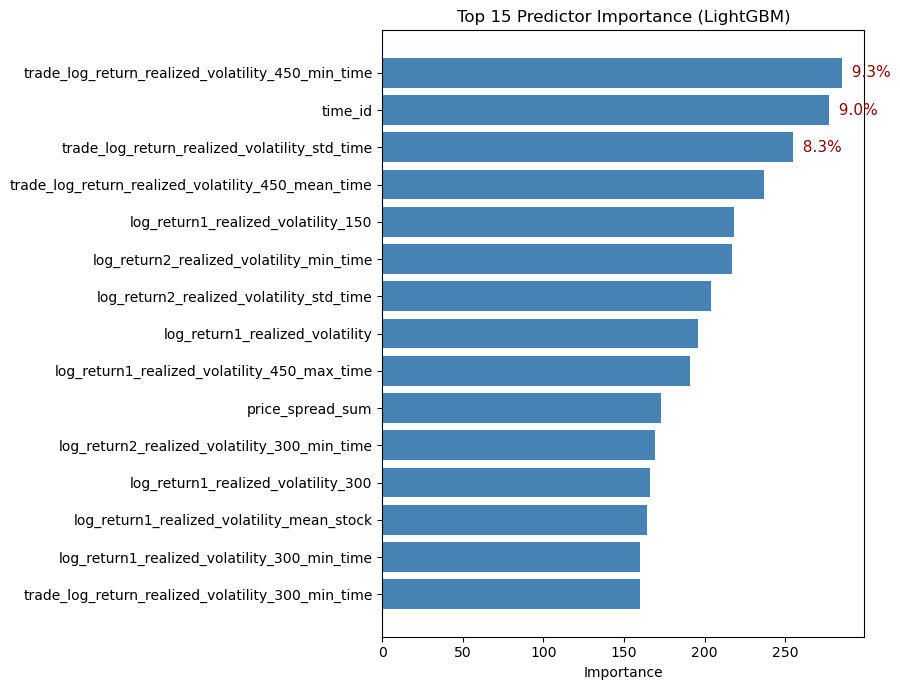

In [24]:
# contribution of predictors in LGBM
plt.figure(figsize=(9, 7))
feature_names_lgb = np.array(X_lgb.columns)
importance_values_lgb = lgbm_final.feature_importances_
top15_indices_lgb = np.argsort(importance_values_lgb)[-15:]
top15_features_lgb = feature_names_lgb[top15_indices_lgb]
top15_importances_lgb = importance_values_lgb[top15_indices_lgb]
top15_percent_lgb = top15_importances_lgb / top15_importances_lgb.sum() * 100
ax = plt.gca()
ax.barh(top15_features_lgb, top15_importances_lgb, color="steelblue")
ax.set_title("Top 15 Predictor Importance (LightGBM)")
ax.set_xlabel("Importance")
top3_idx_lgb = np.argsort(top15_importances_lgb)[-3:]
for idx in top3_idx_lgb:
    feat = top15_features_lgb[idx]
    pct = top15_percent_lgb[idx]
    val = top15_importances_lgb[idx]
    ax.text(val, feat, f"  {pct:.1f}%", va="center", fontsize=11, color="darkred")
plt.tight_layout()
plt.show()

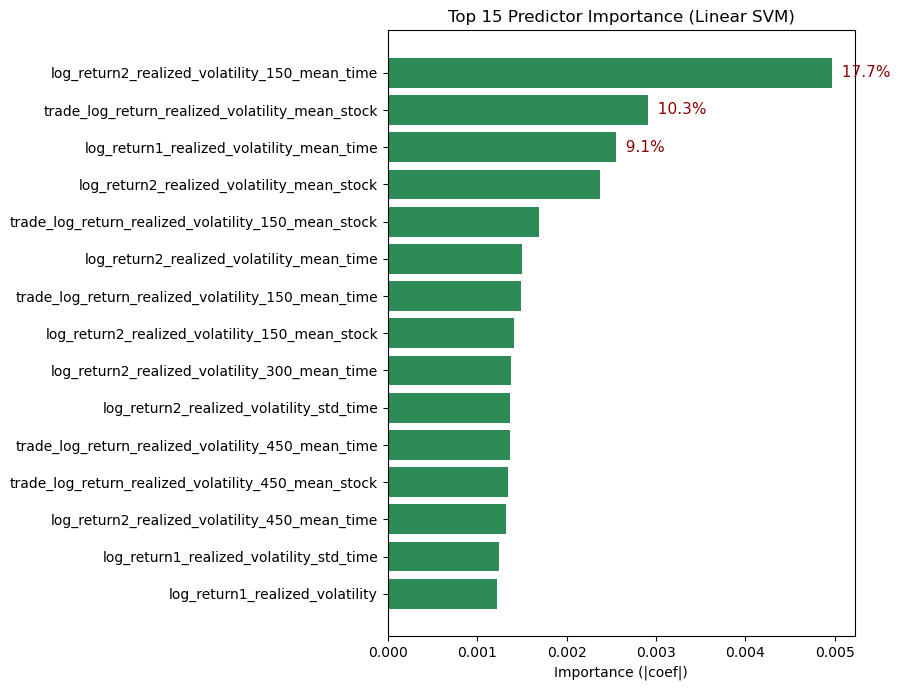

In [25]:
# contribution of predictors in SVM
plt.figure(figsize=(9, 7))
feature_names_svm = np.array(X_svm.columns)
importance_values_svm = np.abs(svm_final.coef_)
top15_indices_svm = np.argsort(importance_values_svm)[-15:]
top15_features_svm = feature_names_svm[top15_indices_svm]
top15_importances_svm = importance_values_svm[top15_indices_svm]
top15_percent_svm = top15_importances_svm / top15_importances_svm.sum() * 100
ax = plt.gca()
ax.barh(top15_features_svm, top15_importances_svm, color="seagreen")
ax.set_title("Top 15 Predictor Importance (Linear SVM)")
ax.set_xlabel("Importance (|coef|)")
top3_idx_svm = np.argsort(top15_importances_svm)[-3:]
for idx in top3_idx_svm:
    feat = top15_features_svm[idx]
    pct = top15_percent_svm[idx]
    val = top15_importances_svm[idx]
    ax.text(val, feat, f"  {pct:.1f}%", va="center", fontsize=11, color="darkred")
plt.tight_layout()
plt.show()

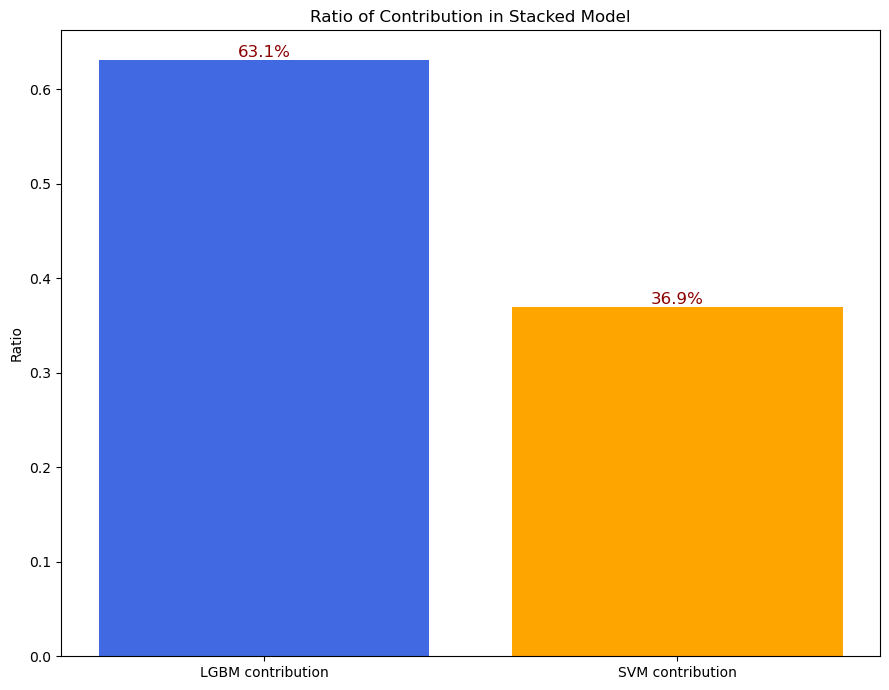

In [26]:
# contribution of LGBM and SVM in the meta LGBM (stacked) model
plt.figure(figsize=(9, 7))
stack_feature_names = np.array(["LGBM contribution", "SVM contribution"])
stack_raw_values = meta_final.feature_importances_
stack_ratio = stack_raw_values / stack_raw_values.sum()
stack_percent = stack_ratio * 100
ax = plt.gca()
ax.bar(stack_feature_names, stack_ratio, color=["royalblue", "orange"])
ax.set_title("Ratio of Contribution in Stacked Model")
ax.set_ylabel("Ratio")
for i, pct in enumerate(stack_percent):
    ax.text(i, stack_ratio[i], f"{pct:.1f}%", ha="center", va="bottom",
            fontsize=12, color="darkred")
plt.tight_layout()
plt.show()

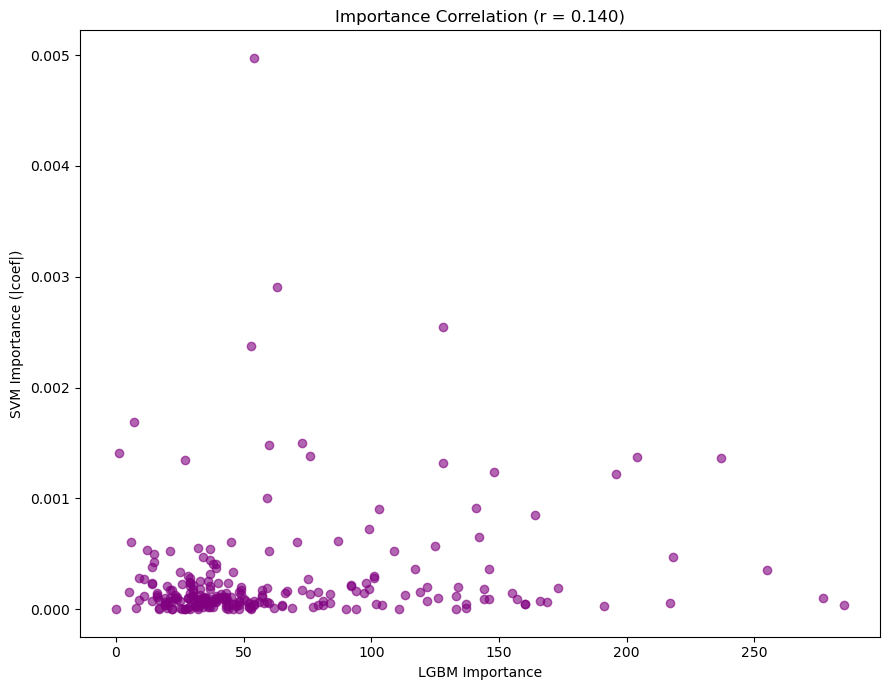

In [27]:
# correlation between most contributed predictors in LGBM and SVM
plt.figure(figsize=(9, 7))
lgb_all = importance_values_lgb
svm_all = importance_values_svm
corr_value = np.corrcoef(lgb_all, svm_all)[0, 1]
ax = plt.gca()
ax.scatter(lgb_all, svm_all, alpha=0.6, color="purple")
ax.set_xlabel("LGBM Importance")
ax.set_ylabel("SVM Importance (|coef|)")
ax.set_title(f"Importance Correlation (r = {corr_value:.3f})")
plt.tight_layout()
plt.show()